##  Imports


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import pprint
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from numpy import newaxis
from sklearn import datasets

## Neural Network Class

In [0]:
class FFNN:
  def __init__(self, n_input, n_output , h = [2]):
    self.nx = n_input
    self.ny = n_output
    self.nh = len(h)
    self.lens = [self.nx] + h + [self.ny]
    self.fake_input = np.array([[1]])

    self.W = {}
    for i in range(1, self.nh + 2):
      self.W[i] = np.random.randn(self.lens[i-1] + 1, self.lens[i]) * np.sqrt(1 / (2 + self.lens[i-1]))
  
  def sigmoid(self, z):
    return 1.0/(1.0 + np.exp(-z))
  
  def softmax(self, x):
    A = np.exp(x)
    return A/sum(A)
  
  def cross_entropy(self,label,pred):
    yl=np.multiply(pred,label)
    yl=yl[yl!=0]
    yl=-np.log(yl)
    yl=np.mean(yl)
    return yl
  
  def sigder(self, x):
    return x*(1 - x)  
  
  def forward(self, x):
    self.A = {}
    self.Z = {}
    self.Z[0] = np.resize(x, (len(x), 1))
    for i in range(1, self.nh + 2):
      self.Z[i-1] = np.vstack((self.fake_input, self.Z[i-1]))
      self.A[i] = np.matmul( self.W[i].T, self.Z[i-1] ) 
      self.Z[i] = self.sigmoid(self.A[i])
    
    self.Z[self.nh + 1] = self.softmax(self.A[self.nh+1])
    
    return self.Z[self.nh + 1]

  def grad(self, train_x, train_y):
    self.forward(train_x) 
    self.dell = {}  
    self.dW = {}
    
    self.dell[self.nh + 1] = self.Z[self.nh + 1] - train_y 
    self.dW[self.nh + 1] = np.matmul(self.Z[self.nh], self.dell[self.nh + 1].T) 
    
    for i in range(self.nh, 0, -1): 
      tmp = np.matmul(self.W[i+1][1:,:], self.dell[i+1])
      self.dell[i] =  tmp * self.sigder(self.Z[i][1:])
      self.dW[i] =  np.matmul(self.Z[i - 1], self.dell[i].T)

  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()

  def fit(self, X, Y, val_x, val_y, epochs=100, learning_rate=0.01, display_loss=False):      

    if display_loss:
      loss = {}
      loss2 = {}
    
    for epoch in range(epochs):
      if( epoch%10 == 0):
        print("epoch: "+str(epoch) +" running.......")
      dW = {}
      for i in range(1, self.nh+2):
        dW[i] = np.zeros((1 + self.lens[i-1], self.lens[i]))
      for x, y in zip(X, Y):
        self.grad(np.asarray(x).T, np.asarray(y))
        for i in range(1, self.nh+2):
          self.W[i] -= learning_rate * self.dW[i] 
  
      if display_loss:
        Y_pred = self.predict(X)
        Y_pred = Y_pred[:,:,newaxis] 
        Y_pred2 = self.predict(val_x)
        Y_pred2 = Y_pred2[:,:,newaxis] 
        loss[epoch] = self.cross_entropy(Y, Y_pred)
        loss2[epoch] = self.cross_entropy(val_y, Y_pred2)
    
    if display_loss:
      lists = sorted(loss.items())
      lists2 = sorted(loss2.items())
      x, y = zip(*lists)
      x2, y2 = zip(*lists2)
      plt.plot(x, y, 'r', label = 'Training error')
      plt.plot(x2, y2,'b' , label = 'Validation error')
      plt.xlabel('Epochs')
      plt.ylabel('CE')
      plt.legend(loc="upper left")
      plt.show()

## Load Dataset

In [0]:
iris = datasets.load_iris()

x = iris.data
y = iris.target

X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size = .3)

## Standardization of inputs and Hot Encoding

In [0]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

enc = OneHotEncoder()
Y_train_val = Y_train
Y_val_val = Y_val
Y_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray() 
Y_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()

Y_train = Y_train[:,:,newaxis]
Y_val = Y_val[:,:,newaxis]


## Play with Parameters and Test

epoch: 0 running.......
epoch: 10 running.......
epoch: 20 running.......
epoch: 30 running.......
epoch: 40 running.......
epoch: 50 running.......
epoch: 60 running.......
epoch: 70 running.......
epoch: 80 running.......
epoch: 90 running.......


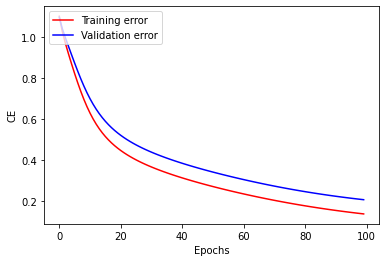

Training accuracy 0.9905
Validation accuracy 0.9111


In [0]:
ffsn_multi = FFNN(4,3,[5])

ffsn_multi.fit(X_train,Y_train, X_val, Y_val, epochs=100,learning_rate=.01, display_loss=True)

Y_pred_train = ffsn_multi.predict(X_train)
Y_pred_train = np.argmax(Y_pred_train,1)

Y_pred_val = ffsn_multi.predict(X_val)
Y_pred_val = np.argmax(Y_pred_val,1)

accuracy_train = accuracy_score(Y_pred_train, Y_train_val)
accuracy_val = accuracy_score(Y_pred_val, Y_val_val)

print("Training accuracy", round(accuracy_train, 4))
print("Validation accuracy", round(accuracy_val, 4))

## Resultant Weights

In [0]:
pprint.pprint(ffsn_multi.W)

{1: array([[ 0.98395799,  0.45294205,  0.02485852, -1.48224627,  0.58672275],
       [ 0.72041604, -0.70197368, -0.33125711, -0.33213267, -0.25134398],
       [-1.42660354,  0.16828344,  0.83635222, -0.43263352, -0.12679346],
       [ 1.38705126, -1.22496849, -0.91648064,  1.41957303, -0.74736107],
       [ 0.61095535, -1.08593673, -1.2618097 ,  1.75964047, -1.38532747]]),
 2: array([[-0.59360367,  0.13817983,  0.56712854],
       [-2.5542685 ,  1.58900911,  0.69731884],
       [ 1.88504456,  0.23539915, -2.46630673],
       [ 2.27377614, -0.21787378, -2.09644008],
       [-2.05229282, -1.12896706,  2.75869034],
       [ 0.93678805,  0.65658129, -2.11413308]])}


## Multi-Classification of Iris Data 

### Using K-neighbors

In [0]:
from sklearn import datasets
iris = datasets.load_iris()

In [0]:
x = iris.data
y = iris.target

In [0]:
print(x, type(x))
print(y, type(y))

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = .3)

In [0]:
from sklearn import neighbors
classifier = neighbors.KNeighborsClassifier()

In [0]:
classifier.fit(X_train, Y_train)

In [0]:
prediction = classifier.predict(X_test)

In [0]:
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test,prediction))

###Using GaussianNB

In [0]:
from sklearn.naive_bayes import GaussianNB
naive_classifier= GaussianNB()
# from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = .3)
y = naive_classifier.fit(X_train, Y_train).predict(X_test)
# pr=naive_classifier.predict(iris.data)
from sklearn.metrics import accuracy_score
score = accuracy_score(Y_test, y)

In [0]:
print(score)

In [0]:
print(x.shape)

### Using MLP classifier

In [0]:

scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)
# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier( solver = 'lbfgs', alpha = 1e-5, hidden_layer_sizes = (3,3),
                     random_state = 1)
clf.fit(X_train, Y_train)
y = clf.predict(X_test)
score = accuracy_score(Y_test, y)
print(score)

In [0]:
print(X_train)

In [0]:
print(Y_train)

In [0]:
#@title IRIS CLASS PREDICTOR(inputs in cm)
Sepal_length  = 7 #@param {type:"slider", min:0, max:10, step:0.1}
Sepal_width = 3.5 #@param {type:"slider", min:0, max:10, step:0.1}
Petal_length = 5.2 #@param {type:"slider", min:0, max:10, step:0.1}
Petal_width = 1.3 #@param {type:"slider", min:0, max:10, step:0.1}

input1 = [[Sepal_length, Sepal_width, Petal_length, Petal_width]]
y = clf.predict(input1)
if( y == 0):
  print('Iris Setosa')
elif(y == 1):
  print('Iris Versicolour')
else:
  print(' Iris Virginica')